# Data Analysis


The goal of this document is to use the dataset generated in the data cleaning document to explore the relationship between lecture consumption and student performances in online courses.

In [21]:
import seaborn as sns
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

In [22]:
BASE_DIR = os.path.dirname(os.getcwd())
dataset_path = os.path.join(BASE_DIR,"dataset","cleaned_dataset.csv")
df = pd.read_csv(dataset_path)

To start off the process, this analysis will first attempt a classic linear regression model to check for a linear relationship

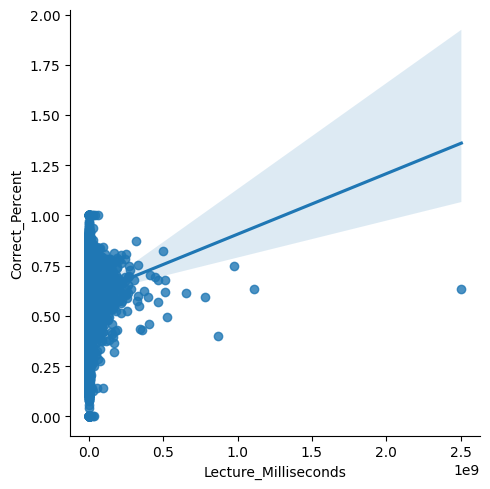

In [23]:
sns.lmplot(x="Lecture_Milliseconds",y="Correct_Percent",data=df)

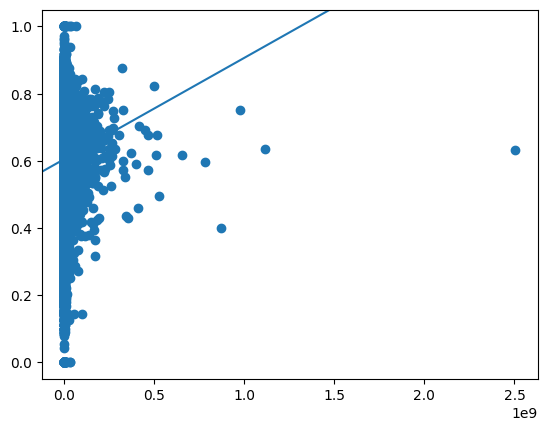

In [24]:
model = LinearRegression()
model.fit(X=df[["Lecture_Milliseconds"]],y=df["Correct_Percent"])
plt.axline((0,model.intercept_),slope=model.coef_[0])
plt.scatter(x="Lecture_Milliseconds",y="Correct_Percent",data=df)

In [25]:
df["Pred"] = model.predict(df[["Lecture_Milliseconds"]])
mean_squared_error(y_pred=df["Pred"],y_true=df["Correct_Percent"])

0.016624009751710623

It appears from this analysis that there does not seem to be a linear correlation between time spent on lecture and the percentage of correct questions answered. However, the mean squared error of the linear regression analysis seems to be relatively low. This could be due to the limitations of the scatterplot visualization. As there are a lot of data points, they overlap, and seem to take up a large amount of area, but may only have one observation per space while other places may have a lot more. The below visualization attempts to make use of adjustments to the opacity values of each data point.

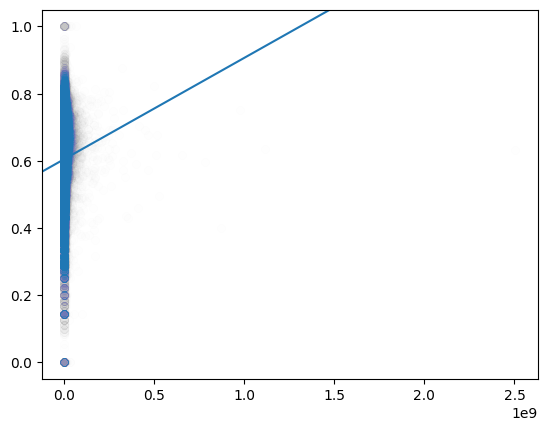

In [26]:
plt.axline((0,model.intercept_),slope=model.coef_[0])
plt.scatter(x="Lecture_Milliseconds",y="Correct_Percent",data=df, alpha=.005)

It still seems that most of the data points spend very few hours on lectures, and have scores ranging from 10% accuracy to 100% accuracy. It seems that the data has no clear correlation. A similar conclusion can be drawn from a more appropiate logistic regression model. While the model shows a strong correlation of p = .004 between Lecture Milliseconds and the Correct Percent, the increase per millisecond is incredibly small, and thus, does not make the finding very significant.

In [27]:
results = smf.logit("Correct_Percent ~ Lecture_Milliseconds",data=df).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.649781
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Correct_Percent   No. Observations:                42488
Model:                          Logit   Df Residuals:                    42486
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                 -0.4348
Time:                        11:43:29   Log-Likelihood:                -27608.
converged:                       True   LL-Null:                       -19242.
Covariance Type:            nonrobust   LLR p-value:                     1.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4230      0.010     41.138      0.000       0.403       0.443
Lecture_Milliseconds  1.709e-09      6e-10      2.849      0.004    5.33e-10    2.88e-09
========================================================================================
"""

In [28]:
mean_squared_error(results.predict(df),df["Correct_Percent"])

0.016599518473929764

In [29]:
import statsmodels.api as sm

In [30]:
results2 = smf.glm("Correct_Percent ~ Lecture_Milliseconds",data=df,family=sm.families.Binomial()).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Correct_Percent   No. Observations:                42488
Model:                            GLM   Df Residuals:                    42486
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19336.
Date:                Tue, 02 Dec 2025   Deviance:                       3064.2
Time:                        11:43:29   Pearson chi2:                 2.97e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0002283
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4230      0.010     41.138      0.000       0.403       0.443
Lecture_Milliseconds  1.709e-09      6e-10      2.849      0.004    5.33e-10    2.88e-09
========================================================================================
"""

In [31]:
mean_squared_error(results2.predict(df),df["Correct_Percent"])

0.016599518473929768

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                42488
Model:                            GLM   Df Residuals:                    42486
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2356e+05
Date:                Tue, 02 Dec 2025   Deviance:                   4.3101e+05
Time:                        12:12:13   Pearson chi2:                 4.29e+05
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01553
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6503      0.001    9

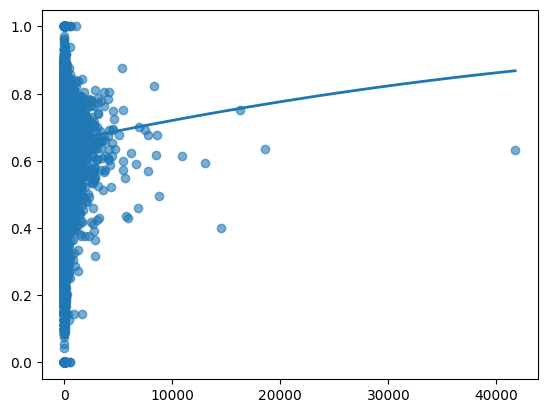

In [ ]:
df["Lecture_Minutes"] = df["Lecture_Milliseconds"] / 1000 / 60
successes = df["Questions_Correct"]
failures = (df["Questions_Answered"] - df["Questions_Correct"])
endog = np.vstack([successes, failures]).T  # shape (n_obs, 2)

# Explanatory variables (add constant for intercept)
exog = sm.add_constant(df[["Lecture_Minutes"]])

attempt3 = sm.GLM(endog, exog, family=sm.families.Binomial()).fit()

print(attempt3.summary())

# log odds and coeff calc
coeff = attempt3.params["Lecture_Minutes"]
se = attempt3.bse["Lecture_Minutes"]
odds_ratio = np.exp(coeff)

print(f"\nLecture_Minutes coefficient (log-odds): {coeff:.4f}")
print(f"Odds ratio per minute: {odds_ratio:.4f}")

# creating the line for plotting
x_min, x_max = df["Lecture_Minutes"].min(), df["Lecture_Minutes"].max()
xs = np.linspace(x_min, x_max, 100)
exog_pred = sm.add_constant(pd.DataFrame({"Lecture_Minutes": xs}))
predicted_prob = attempt3.predict(exog_pred) 

# plotting
plt.scatter(df["Lecture_Minutes"], df["Questions_Correct"] / df["Questions_Answered"], alpha=0.6, label="observed proportion")
plt.plot(xs, predicted_prob, label="fitted probability (GLM Binomial)", linewidth=2)

In [36]:
y_true = df["Questions_Correct"] / df["Questions_Answered"]

exog = sm.add_constant(df[["Lecture_Minutes"]])
y_pred = attempt3.predict(exog)

mse = mean_squared_error(y_true, y_pred)
print("MSE:", mse)

MSE: 0.019295671022566133


Due to the log odds, it would appear that there exists no linear correlation. The log odds would suggest that increasing lecture time roughly does not increase percentage of correct answers as the log odds is rounded to 0, meaning that there is either no correlation or that the correlation is so small that it does not matter